<a href="https://colab.research.google.com/github/Nunikyuni/forced_cough_Covid-19_Gemastik_v3_0.98_new/blob/main/forced_cough_Covid_19_Gemastik_v3_0_98_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
# from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Input
# from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l1
from keras.utils.vis_utils import plot_model
from datetime import datetime
from sklearn import metrics
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
plt.switch_backend('agg')
import itertools
import scipy as sp
from scipy import signal
import xgboost as xgb
import joblib
from glob import glob
import urllib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

Connecting Kaggle to Collab to accsess dataset 

In [2]:
!pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wahyuniindraswari","key":"06b06a1119c46fbf0130ce10e0e1c3d4"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets list -s 'COVID-19 Cough Recordings'

ref                                           title                                size  lastUpdated          downloadCount  
--------------------------------------------  -----------------------------------  ----  -------------------  -------------  
himanshu007121/coughclassifier-trial          COVID-19 Cough Recordings            95MB  2021-06-08 13:06:01            792  
andrewmvd/covid19-cough-audio-classification  Covid-19 Cough Audio Classification   1GB  2021-07-26 05:20:02            423  
nasrulhakim86/coughvid-wav                    COUGHVID dataset                      9GB  2021-08-30 04:00:40             33  


In [5]:
!kaggle datasets download -d 'himanshu007121/coughclassifier-trial'

 81% 77.0M/94.9M [00:01<00:00, 39.9MB/s]
100% 94.9M/94.9M [00:01<00:00, 63.3MB/s]


In [6]:
import zipfile,os,shutil

In [7]:
fileZip = "coughclassifier-trial.zip"
extracZip = zipfile.ZipFile(fileZip, 'r')
extracZip.extractall("datasets")

In [8]:
#Loading CSV file
train_csv = pd.read_csv("../content/datasets/cough_trial_extended.csv")
# dataset = "../input/coughclassifier-trial/cough_trial_extended.csv"
train_csv

,file_properties,class
0,0v8MGxNetjg_ 10.000_ 20.000.wav,not_covid
1,1j1duoxdxBg_ 70.000_ 80.000.wav,not_covid
2,1MSYO4wgiag_ 120.000_ 130.000.wav,not_covid
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,not_covid
4,cov1.wav,covid
...,...,...
165,-bZrDCS8KAg_ 70.000_ 80.000.wav,not_covid
166,-ej81N6Aqo4_ 0.000_ 8.000.wav,not_covid
167,-gvLnl1smfs_ 90.000_ 100.000.wav,not_covid
168,-hu5q-Nn4BM_ 70.000_ 80.000.wav,not_covid


In [9]:
train_csv['class'].unique()

array(['not_covid', 'covid'], dtype=object)

In [10]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
for i in range(tot_rows):
    source = train_csv['file_properties'][i]
    filename = '../content/datasets/trial_covid/'+source
    y,sr = librosa.load(filename, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
    plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [11]:
train_csv.shape

(170, 2)

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [12]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Writing data to csv file

We write the data to a csv file

In [13]:
file = open('data_new_extended.csv', 'w')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for i in range(tot_rows):
        source = train_csv['file_properties'][i]
        file_name = '../content/datasets/trial_covid/'+source
        y,sr = librosa.load(file_name, mono=True, duration=5)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{source[:-3].replace(".", "")} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        file = open('data_new_extended.csv', 'a')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

# Analysing the Data in Pandas

In [14]:
data = pd.read_csv('../content/datasets/data_new_extended.csv')
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0v8MGxNetjg_,0.519951,0.045853,1612.895795,1411.838677,2907.580566,0.107019,-376.876007,111.017372,-31.904015,6.622254,-0.816813,-4.456445,-0.198702,-3.759593,-5.181573,-0.665209,-0.656475,-7.439712,-1.034580,-0.203084,-3.513495,-1.745704,-3.011878,-2.878482,-2.106427,-4.026825,not_covid
1,1j1duoxdxBg_,0.535472,0.001771,2892.087076,2467.408141,5072.664388,0.148584,-519.158447,60.781284,-13.722884,52.145428,0.051050,-2.534910,16.103621,-1.494580,4.123252,11.030884,-0.156307,-0.909972,7.216461,-1.719630,3.903021,3.653039,3.043882,2.439958,2.781968,2.195162,not_covid
2,1MSYO4wgiag_,0.496666,0.033657,3429.061935,2788.634413,6886.288452,0.225315,-282.297913,48.581680,-15.522367,12.710723,4.199980,-7.577727,-19.324192,-12.037646,-16.901484,13.693965,0.829615,-6.066336,-4.167640,1.017302,-0.523806,0.538693,-8.855953,-2.927977,-1.118562,-5.906227,not_covid
3,1PajbAKd8Kg_,0.407549,0.013452,2710.811637,2664.287550,5778.474935,0.142076,-346.857300,75.765617,-7.648193,11.362122,11.365475,1.842426,-7.957006,-4.264208,-8.283970,3.105164,-2.838680,5.053118,-0.291308,0.987186,-2.447526,3.692367,2.312328,-2.059656,-4.772599,-0.503851,not_covid
4,cov1,0.412697,0.059004,1555.648634,1418.599932,2870.737092,0.133998,-340.588013,104.156700,-32.228443,-13.615362,-3.029665,0.512090,-21.811838,-17.781813,-9.270074,-5.505614,-5.385944,-8.247169,0.940006,-5.701087,-6.326630,-1.080040,-1.812609,-2.518986,-3.684266,-3.564146,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,#NAME?,0.492974,0.005093,1600.647469,2300.999728,3660.644531,0.047815,-543.776916,119.100296,23.902969,23.709490,8.697512,10.839913,1.680631,7.781387,1.686800,3.687685,-2.675646,-1.250754,-2.634280,1.647435,0.647164,1.602689,-2.469729,0.704325,-5.352920,-1.281080,not_covid
166,#NAME?,0.400283,0.052132,2664.129566,2563.440387,5518.182373,0.121514,-290.840607,85.514412,-10.986873,10.970556,1.218062,9.801715,0.316855,-7.225134,-2.831453,2.981585,-8.843078,-4.629812,-7.424622,-4.511141,-7.482200,-4.865530,-6.353733,-5.024187,-8.422812,-0.831208,not_covid
167,#NAME?,0.704281,0.058739,3090.031219,2740.856272,6530.841064,0.179077,-75.595451,68.849228,-11.665833,17.189640,-4.745080,2.061405,-8.534120,5.379293,-4.747192,5.724702,-6.867559,0.677697,-7.535110,0.602187,-6.629556,0.659050,-4.125256,0.734950,-4.655417,-0.645009,not_covid
168,#NAME?,0.424896,0.044159,3173.872023,2482.951387,5768.306478,0.221743,-264.064514,58.729767,-7.446329,15.075655,-24.546654,-7.761268,-29.158249,1.814475,-19.110003,-9.132167,-3.354258,-0.625627,0.677355,-3.651989,-6.051375,1.211774,-14.923816,-11.180058,-8.861262,-5.078876,not_covid


In [15]:
data.shape

(170, 28)

In [16]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

## Encoding the Labels

In [17]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

## Scaling the Feature columns

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## Dividing data into training and Testing set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [20]:
X_train.shape

(119, 26)

In [21]:
y_test.shape

(51,)

In [22]:
X_train.shape[1]

26

In [23]:
y_train.shape

(119,)

In [24]:
#check image shape
X_train[0].shape

(26,)

In [25]:
# #reshape data to fit model
# X_train = X_train.reshape(119,26,26,1)
# X_test = X_test.reshape(51,26,26,1)

In [26]:
# #one-hot encode target column
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_train[0]

In [27]:
# #create model
# model = Sequential()
# #add model layers
# model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
# model.add(Conv2D(32, kernel_size=3, activation='relu'))
# model.add(Flatten())
# model.add(Dense(10, activation='softmax'))

In [28]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

# Classification with Keras

## Building our Network

Saved model to disk


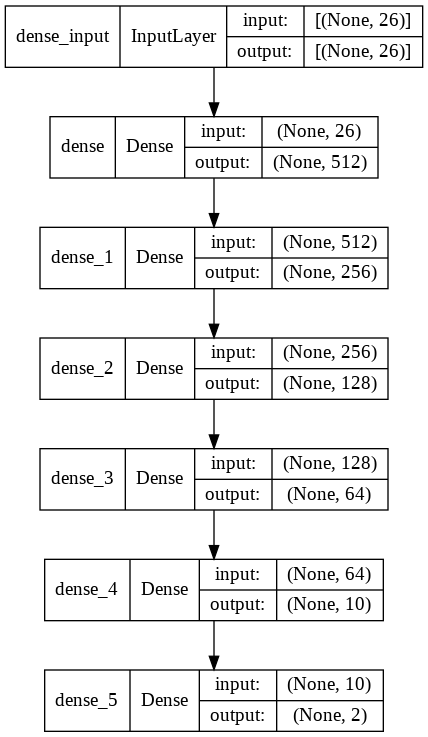

In [30]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# plot model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               13824     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dense_5 (Dense)             (None, 2)                 22        
                                                                 
Total params: 186,976
Trainable params: 186,976
Non-trai

In [32]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
1/1 [==============================] - 1s 795ms/step - loss: 0.6584 - accuracy: 0.6303
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 0.4586 - accuracy: 0.8739
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 0.3710 - accuracy: 0.8739
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 0.3153 - accuracy: 0.8739
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 0.2762 - accuracy: 0.8739
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 0.2440 - accuracy: 0.8739
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2115 - accuracy: 0.8739
Epoch 8/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1807 - accuracy: 0.8739
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 0.1557 - accuracy: 0.8739
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1403 - accuracy: 0.8739
Epoch 11/100
1/1 [

In [33]:
test_loss, test_acc = model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.1107 - accuracy: 0.9804


In [34]:
print('test_acc: ',test_acc)

test_acc:  0.9803921580314636


In [35]:
predictions = model.predict(X_test)
print(predictions[0].shape)
print(np.sum(predictions[0]))
print(predictions[:4])
print(y_test[:4])

(2,)
1.0
[[2.5131368e-07 9.9999976e-01]
 [2.8041035e-19 1.0000000e+00]
 [3.5019457e-07 9.9999964e-01]
 [9.9989176e-01 1.0822527e-04]]
[1 1 1 0]


In [36]:
!tar -zcvf outputname.tar.zip /kaggle/working

tar: Removing leading `/' from member names
tar: /kaggle/working: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [37]:
df = pd.DataFrame(predictions, columns = ['Negative','Positive'])

In [38]:
a = df.iloc[:,0] < df.iloc[:,1] 
a = a*1

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [40]:
a.to_numpy()

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [41]:
y_test

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

Model: auROC=0.989


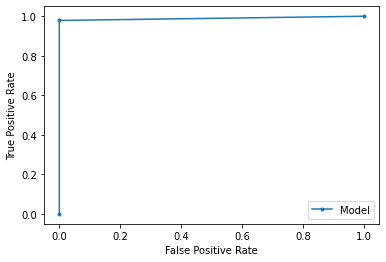

In [42]:
# summarize score
print('Model: auROC=%.3f' % (roc_auc_score(y_test, a)))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, a)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()